In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 🚨 Select running mode

In [2]:
#Select whether part E, C or A is run

running_e = False
running_c = False
running_a = True 

### <span style='color:#ff5f27'> 📝 Imports

In [3]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

if running_e or running_c:
    location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']

if running_a:
    locations_str = secrets.get_secret("SENSOR_LOCATIONS_JSON").value
    locations = json.loads(locations_str)
    country = locations[0]['country']
    city=locations[0]['city']

2025-11-18 15:57:59,093 INFO: Initializing external client
2025-11-18 15:57:59,094 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 15:58:00,894 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272015


In [5]:
#Select version of feature group
if running_e:
    aq_version = 1
    w_version = 1

if running_c:
    aq_version = 2
    w_version = 1

if running_a:
    aq_version = 3
    w_version = 2

#Get feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=aq_version,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [6]:
# Select features for training data
from hsfs.feature import Feature

if running_e:
    selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

#C include lagged data
if running_c:
    selected_features = air_quality_fg.select(['pm25', 'date','lagged_aq_1_day', 'lagged_aq_2_days', 'lagged_aq_3_days']).join(weather_fg.select_all(), on=['city'])

#For A, features for each sensor are stored seperately
if running_a:
    all_selected_features = []

    for location in locations:
        street = location["street"]
    
        selected_features = air_quality_fg.select(['pm25', 'date', 'lagged_aq_1_day', 'lagged_aq_2_days', 'lagged_aq_3_days']).join(weather_fg.select_all(), on=['city']).filter(air_quality_fg.street == street)
        all_selected_features.append(selected_features)

all_selected_features[2].show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


,pm25,date,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,weather_date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_city
0,27.0,2014-01-01 00:00:00+00:00,NaN,NaN,NaN,2014-01-01 00:00:00+00:00,5.452500,4.300000,27.345785,139.581955,edinburgh
1,24.0,2014-01-02 00:00:00+00:00,27.0,NaN,NaN,2014-01-02 00:00:00+00:00,5.852500,0.400000,26.081993,214.857193,edinburgh
2,29.0,2014-01-03 00:00:00+00:00,24.0,27.0,NaN,2014-01-03 00:00:00+00:00,5.921250,6.000000,43.921474,199.560287,edinburgh
3,30.0,2014-01-04 00:00:00+00:00,29.0,24.0,27.0,2014-01-04 00:00:00+00:00,4.721251,0.200000,31.072817,215.917099,edinburgh
4,23.0,2014-01-05 00:00:00+00:00,30.0,29.0,24.0,2014-01-05 00:00:00+00:00,4.065000,9.900001,27.276978,190.786789,edinburgh
5,34.0,2014-01-06 00:00:00+00:00,23.0,30.0,29.0,2014-01-06 00:00:00+00:00,7.487916,3.700000,35.581772,202.436111,edinburgh
6,21.0,2014-01-07 00:00:00+00:00,34.0,23.0,30.0,2014-01-07 00:00:00+00:00,7.481666,0.000000,35.188046,220.146851,edinburgh
7,25.0,2014-01-08 00:00:00+00:00,21.0,34.0,23.0,2014-01-08 00:00:00+00:00,6.700416,0.000000,26.758923,237.365891,edinburgh
8,33.0,2014-01-09 00:00:00+00:00,25.0,21.0,34.0,2014-01-09 00:00:00+00:00,4.283750,0.000000,20.469410,257.879761,edinburgh
9,20.0,2014-01-10 00:00:00+00:00,33.0,25.0,21.0,2014-01-10 00:00:00+00:00,4.675416,1.000000,20.390114,237.283646,edinburgh


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [7]:
#Select version of feature group
if running_e:
    fv_version = 2 

if running_c:
    fv_version = 3 

if running_a:
    i=0
    feature_views = []
    for location in locations:
        fv_version = 4+i


        feature_view = fs.get_or_create_feature_view(
            name='air_quality_fv',
            description="weather features with air quality as the target",
            version=fv_version,
            labels=['pm25'],
            query=all_selected_features[i],
        )
        feature_views.append(feature_view)
        i+=1

else:
    feature_view = fs.get_or_create_feature_view(
            name='air_quality_fv',
            description="weather features with air quality as the target",
            version=fv_version,
            labels=['pm25'],
            query=selected_features,
        )

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [8]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
if running_e or running_c:
    X_train, X_test, y_train, y_test = feature_view.train_test_split(
        test_start=test_start
    )
#For A, we split each sensor's feature view into train and test sets
if running_a:
    data_sets = {}
    c = 0
    for location in locations:
        data = feature_views[c].train_test_split(
        test_start=test_start
        )
        data_sets[location['street']] = data
        c +=1

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.42s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.96s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.39s) 


In [10]:
#Handle categorical features, converts into numerical values for XGBoost
# if running_a:
#     categorical_transformer=Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])
#     preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, ['street'])], remainder="passthrough")


In [11]:
#Double check
if running_a:
    X_train = data_sets[locations[0]['street']][0]
X_train

,date,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,weather_date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_city
0,2019-03-18 00:00:00+00:00,NaN,NaN,NaN,2019-03-18 00:00:00+00:00,5.330000,0.0,15.941944,239.008041,edinburgh
1,2019-03-19 00:00:00+00:00,11.0,NaN,NaN,2019-03-19 00:00:00+00:00,8.850833,0.1,29.268686,235.155060,edinburgh
2,2019-03-20 00:00:00+00:00,11.0,11.0,NaN,2019-03-20 00:00:00+00:00,11.767501,0.3,30.631746,230.071609,edinburgh
3,2019-03-21 00:00:00+00:00,8.0,11.0,11.0,2019-03-21 00:00:00+00:00,11.617499,0.5,29.091030,228.964096,edinburgh
4,2019-03-22 00:00:00+00:00,14.0,8.0,11.0,2019-03-22 00:00:00+00:00,8.973750,2.1,38.773186,226.136246,edinburgh
...,...,...,...,...,...,...,...,...,...,...
2187,2025-04-26 00:00:00+00:00,29.0,29.0,41.0,2025-04-26 00:00:00+00:00,10.725833,1.1,19.980000,173.277206,edinburgh
2188,2025-04-27 00:00:00+00:00,45.0,29.0,29.0,2025-04-27 00:00:00+00:00,12.955001,0.2,29.758307,209.440353,edinburgh
2189,2025-04-28 00:00:00+00:00,15.0,45.0,29.0,2025-04-28 00:00:00+00:00,14.248750,0.0,24.696104,236.274353,edinburgh
2190,2025-04-29 00:00:00+00:00,26.0,15.0,45.0,2025-04-29 00:00:00+00:00,14.373750,0.4,10.472535,224.629211,edinburgh


In [12]:
if running_e or running_c:
    X_features = X_train.drop(columns=['date'])
    X_test_features = X_test.drop(columns=['date'])

if running_a:
    for location in locations:
        data = data_sets[location['street']]
        X_features = data[0].drop(columns=['date', 'weather_date', 'weather_city'])
        X_test_features = data[1].drop(columns=['date', 'weather_date', 'weather_city'])
        
        #Store this modified train and test data with the original data
        data_sets[location['street']].append(X_features)
        data_sets[location['street']].append(X_test_features)

    

In [13]:
if running_a:
    y_train = data_sets[locations[1]['street']][2]

y_train

,pm25
0,21.0
1,15.0
2,19.0
3,36.0
4,38.0
...,...
2452,46.0
2453,15.0
2454,25.0
2455,34.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [14]:
# Creating an instance of the XGBoost Regressor
if running_e or running_c:
    xgb_regressor = XGBRegressor()
    # Fitting the XGBoost Regressor to the training data
    xgb_regressor.fit(X_features, y_train)

#Build model for each sensor
if running_a:
    models = []
    for location in locations:
        xgb_regressor = XGBRegressor()

        X_features = data_sets[location['street']][4]
        y_train = data_sets[location['street']][2]

        # Fitting the XGBoost Regressor to the training data    
        xgb_regressor.fit(X_features, y_train)

        models.append(xgb_regressor)
    





In [15]:
if running_e or running_c:
    # Predicting target values on the test set
    y_pred = xgb_regressor.predict(X_test_features)

    # Calculating Mean Squared Error (MSE) using sklearn
    mse = mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)

    # Calculating R squared using sklearn
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)

#Make predictions for each sensor
if running_a:
    predictions = {}
    j=0
    for location in locations:
        # Predicting target values on the test set
        model = models[j]
        X_test_features = data_sets[location['street']][5]
        y_pred = model.predict(X_test_features)
        print("Model for sensor in", location['street'])
         
        # Calculating Mean Squared Error (MSE) using sklearn
        y_test = data_sets[location['street']][3]
        mse = mean_squared_error(y_test.iloc[:,0], y_pred)
        print("MSE:", mse)

        # Calculating R squared using sklearn
        r2 = r2_score(y_test.iloc[:,0], y_pred)
        print("R squared:", r2)

        predictions[location['street']] = [y_pred, mse, r2]
        j+=1

Model for sensor in tower street
MSE: 127.78714
R squared: 0.2672928238117277
Model for sensor in salamander st
MSE: 120.24977
R squared: 0.2463849934509964
Model for sensor in st leonards
MSE: 111.18443
R squared: 0.17409828423026918
Model for sensor in balmwell terrace
MSE: 5.565112
R squared: 0.1154924784785949
Model for sensor in st john's road
MSE: 117.11979
R squared: 0.31697797598464317
Model for sensor in queensferry road
MSE: 97.76436
R squared: 0.2582578794557764


In [16]:
#Adding the predictions to teh dataframe
if running_e or running_c:
    df = y_test
    df['predicted_pm25'] = y_pred

#One dataframe per sensor
if running_a:
    dfs = []
    for location in locations:
        y_test = data_sets[location['street']][3]
        df = y_test
        y_pred = predictions[location['street']][0]
        df['predicted_pm25'] = y_pred
        dfs.append(df)

In [17]:
if running_e or running_c:
    df['date'] = X_test['date']
    df = df.sort_values(by=['date'])
    df.head(5)

if running_a:
    k = 0
    for location in locations:
        df = dfs[k]
        X_test = data_sets[location['street']][1]
        df['date'] = X_test['date']
        dfs[k] = df
        k+=1

In [18]:
# Creating a directory for the model artifacts if it doesn't exist

if running_e:
    model_dir = "air_quality_model_e"
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)

    images_dir = model_dir + "/images"
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)

if running_c:
    model_dir = "air_quality_model_c"
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)

    images_dir = model_dir + "/images"
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)

if running_a:
    model_dirs = []
    image_dirs = []
    for location in locations:
        model_dir = f"air_quality_model_a_{location['street']}"
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        
        model_dirs.append(model_dir)

        images_dir = model_dir + "/images"
        if not os.path.exists(images_dir):
            os.mkdir(images_dir)

        image_dirs.append(images_dir)
   


tower street


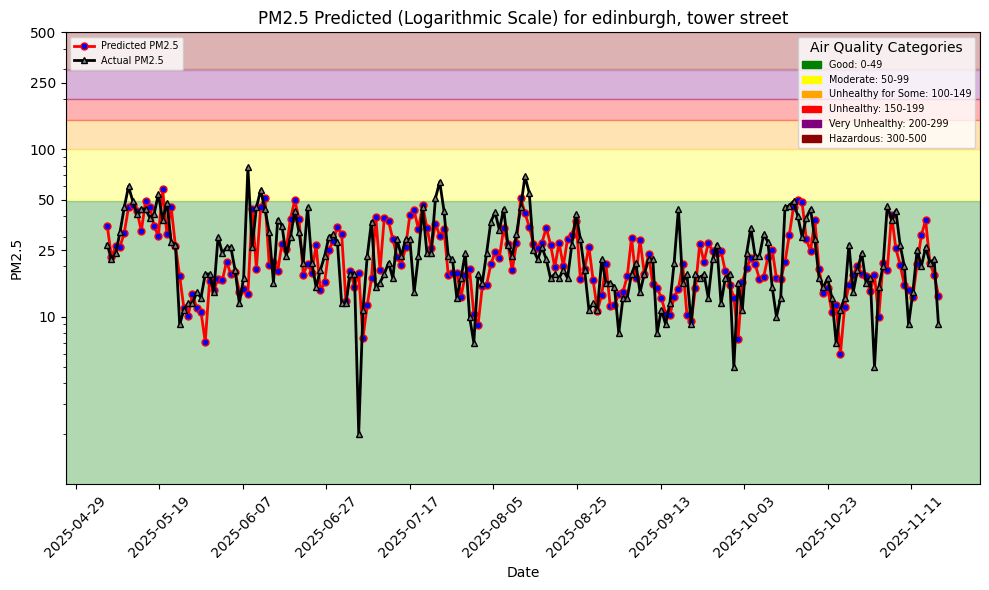

salamander st


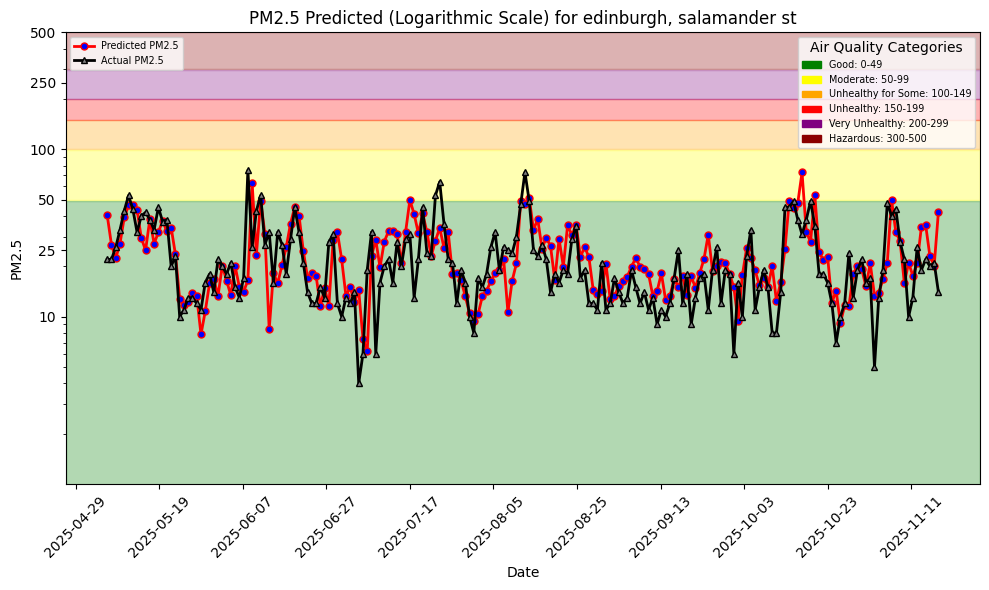

st leonards


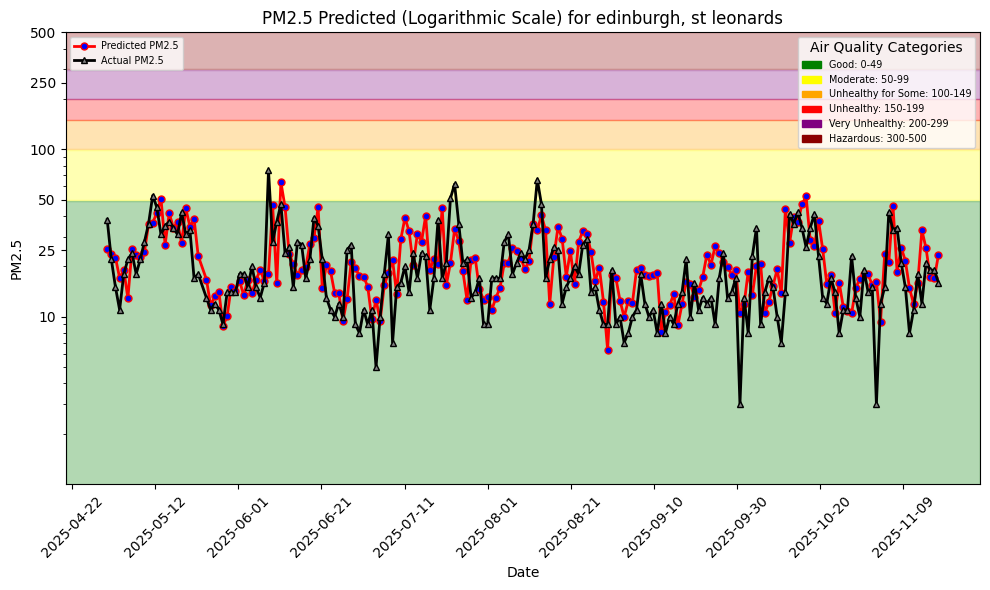

balmwell terrace


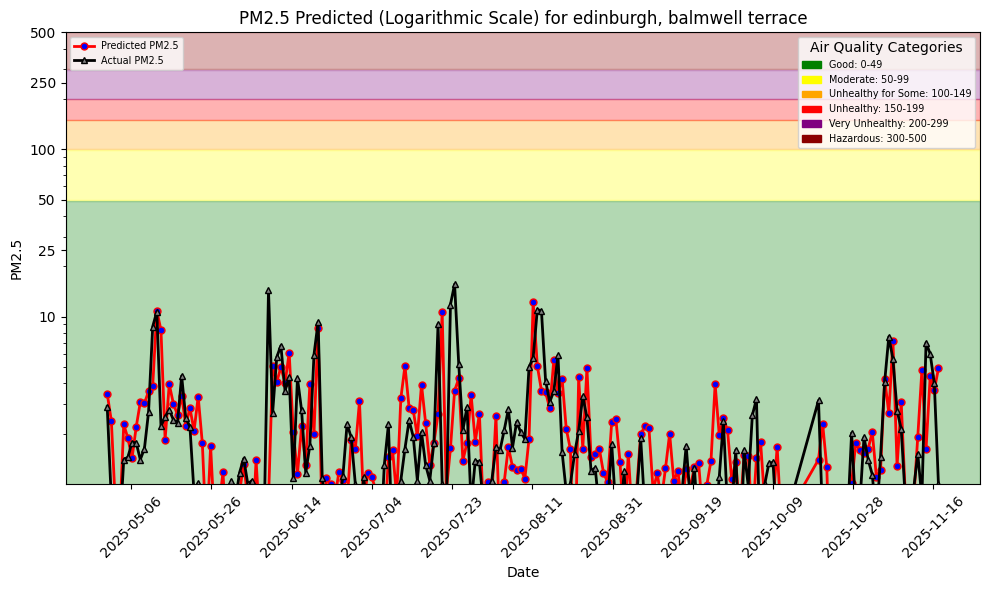

st john's road


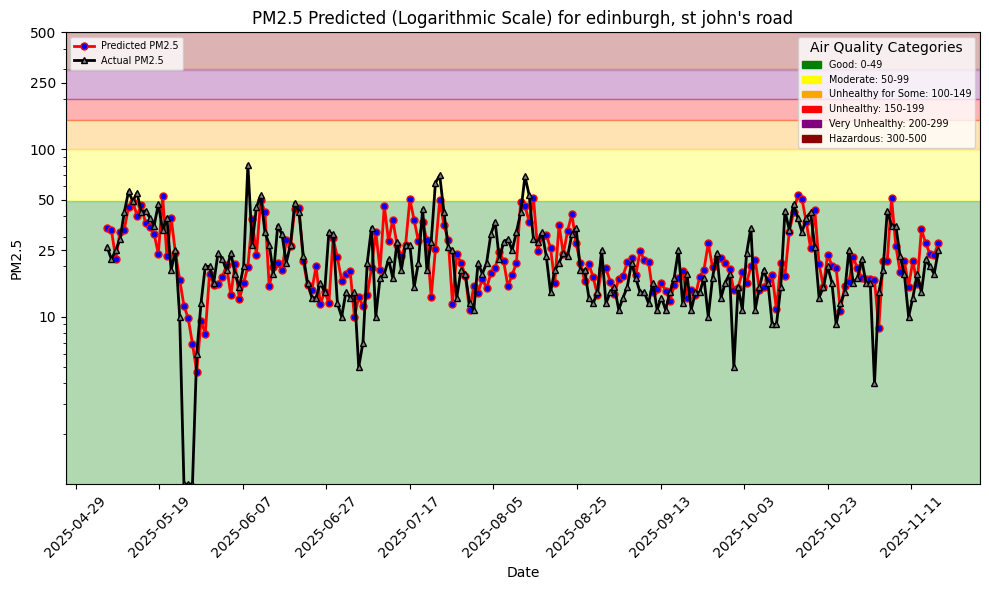

queensferry road


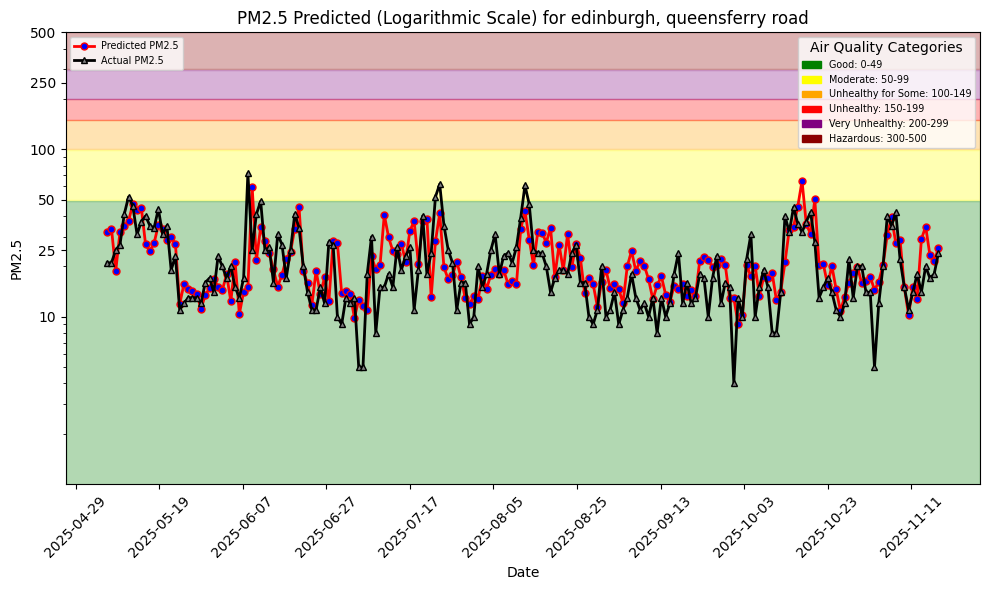

In [19]:
file_path = images_dir + "/pm25_hindcast.png"

if running_e or running_c:
    plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
    plt.show()

if running_a:
    l=0
    for location in locations:
        street = location["street"]
        print(street)
        file_path = image_dirs[l] + "/pm25_hindcast" + str(street) + ".png"
        sensor_df = dfs[l]
        plt = util.plot_air_quality_forecast(city, street, sensor_df, file_path, hindcast=True) 
        plt.show()
        l+=1

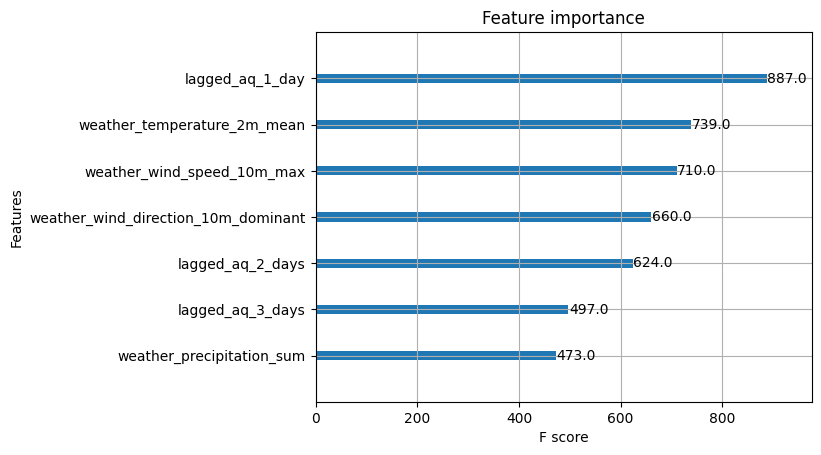

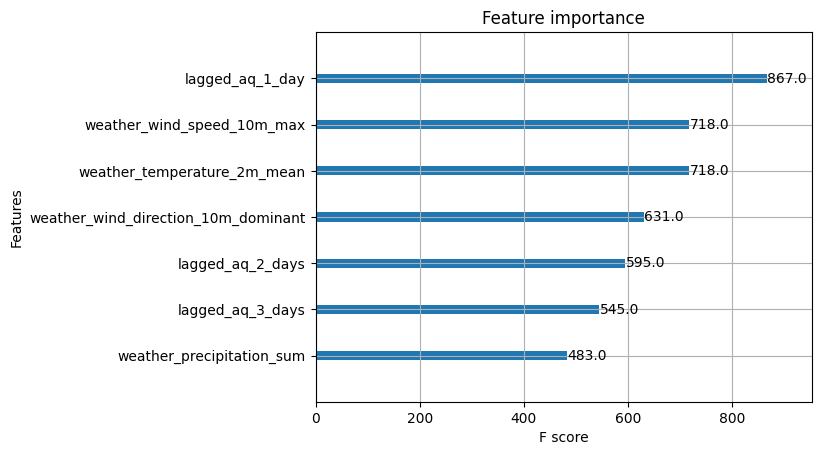

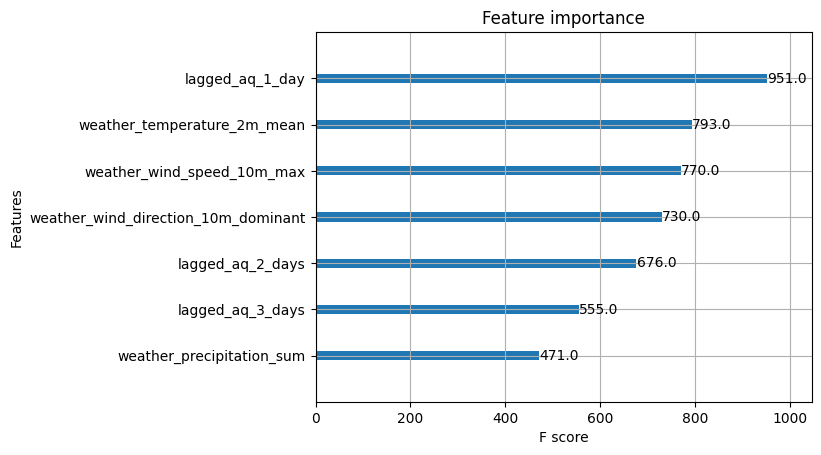

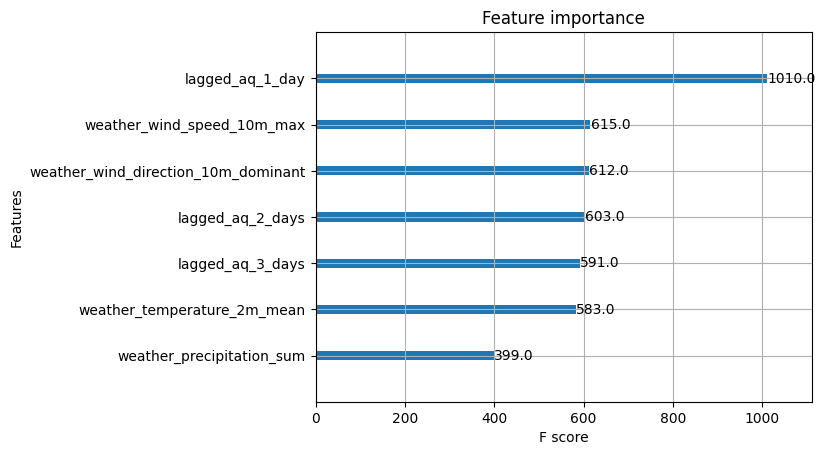

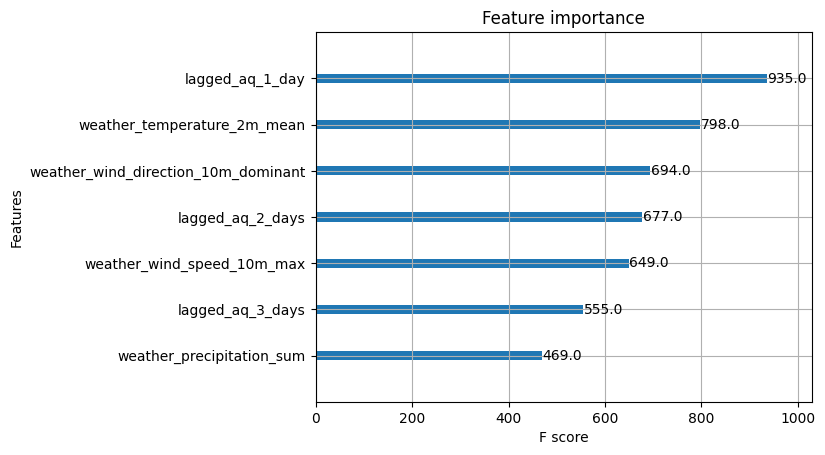

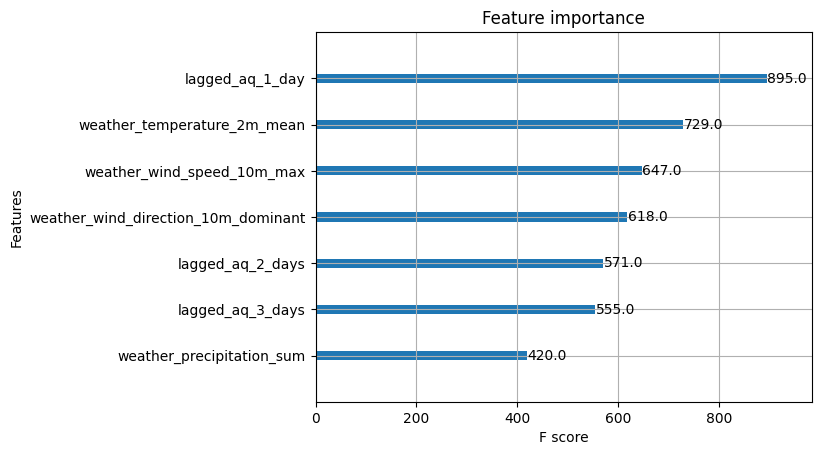

In [20]:
# Plotting feature importances using the plot_importance function from XGBoost
if running_e or running_c:
    plot_importance(xgb_regressor)
    feature_importance_path = images_dir + "/feature_importance.png"
    plt.savefig(feature_importance_path)
    plt.show()

if running_a:
    m=0
    for model in models:
        plot_importance(model)
        file_name = "/feature_importance" + str(locations[m]['street']) + ".png"
        feature_importance_path = image_dirs[m] + file_name
        plt.savefig(feature_importance_path)
        plt.show()
        m+=1

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [21]:
# Saving the XGBoost regressor object as a json file in the model directory

if running_e or running_c:  
    xgb_regressor.save_model(model_dir + "/model.json")

if running_a:
    n=0
    for model in models:
        model.save_model(model_dirs[n] + "/model" + str(locations[n]['street']) + ".json")
        n+=1

In [22]:

if running_e or running_c:  
    res_dict = { 
            "MSE": str(mse),
            "R squared": str(r2),
        }
    
if running_a:
    res_dicts = []
    for location in locations:
        result = predictions[location['street']]
        mse = result[1]
        r2=result[2]

        res_dict = { 
            "MSE": str(mse),
            "R squared": str(r2),
        }

        res_dicts.append(res_dict)
    res_dict = res_dicts

In [24]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'
#Version 3 för del C

if running_e or running_c:
    aq_model = mr.python.create_model(
        name="air_quality_xgboost_model", 
        metrics= res_dict,
        feature_view=feature_view,
        description="Air Quality (PM2.5) predictor",
    )
    aq_model.save(model_dir)

if running_a:
    k=0
    for model in models:
        aq_model = mr.python.create_model(
            name="air_quality_xgboost_model", 
            metrics= res_dict[k],
            feature_view=feature_view,
            description="Air Quality (PM2.5) predictor",
        )

        # Saving the model artifacts to the 'air_quality_model' directory in the model registry
        aq_model.save(model_dirs[k])
        k+=1

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/7


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/8


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/9


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/10


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/11


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/12


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
